<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


     |████████████████████████████████| 6.3 MB 11.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=22dcd60394d2bf182f7bb68fe10f37fc28f13448d62c7578155c0bf9638ae62f
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import plotly.express as px
import plotly.graph_objects as go


In [3]:

import numpy as np
import pandas as pd
import yfinance as yf


In [4]:
nifty=yf.download('^NSEI',start='2018-08-08')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator

In [6]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [7]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [8]:
data=[]

In [9]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [10]:
len(data)

5299

In [11]:
lst=[]
lst.append(data[0:7])

In [12]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [13]:
df=pd.DataFrame()

In [14]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)


In [15]:
df.to_csv('fii.csv')

In [16]:
fii_fig= pd.read_csv('/content/fii.csv')

In [17]:
fii_fig=fii_fig[::-1]

In [18]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [19]:
fii_fig.drop('Index',inplace=True,axis=1)

In [20]:
fii_fig=fii_fig.set_index('Date')

In [21]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

In [22]:
fii_fig['macdfut']=fii_fig['FIIFuture'].ewm(span=150, adjust=False).mean()-fii_fig['FIIFuture'].ewm(span=300, adjust=False).mean()
fii_fig['signalfut']=fii_fig['macdfut'].ewm(span=95,adjust=False).mean()
fii_fig['signal10fut']=fii_fig['macdfut'].ewm(span=20,adjust=False).mean()
fii_fig['histfut']=fii_fig['macdfut']-fii_fig['signalfut']

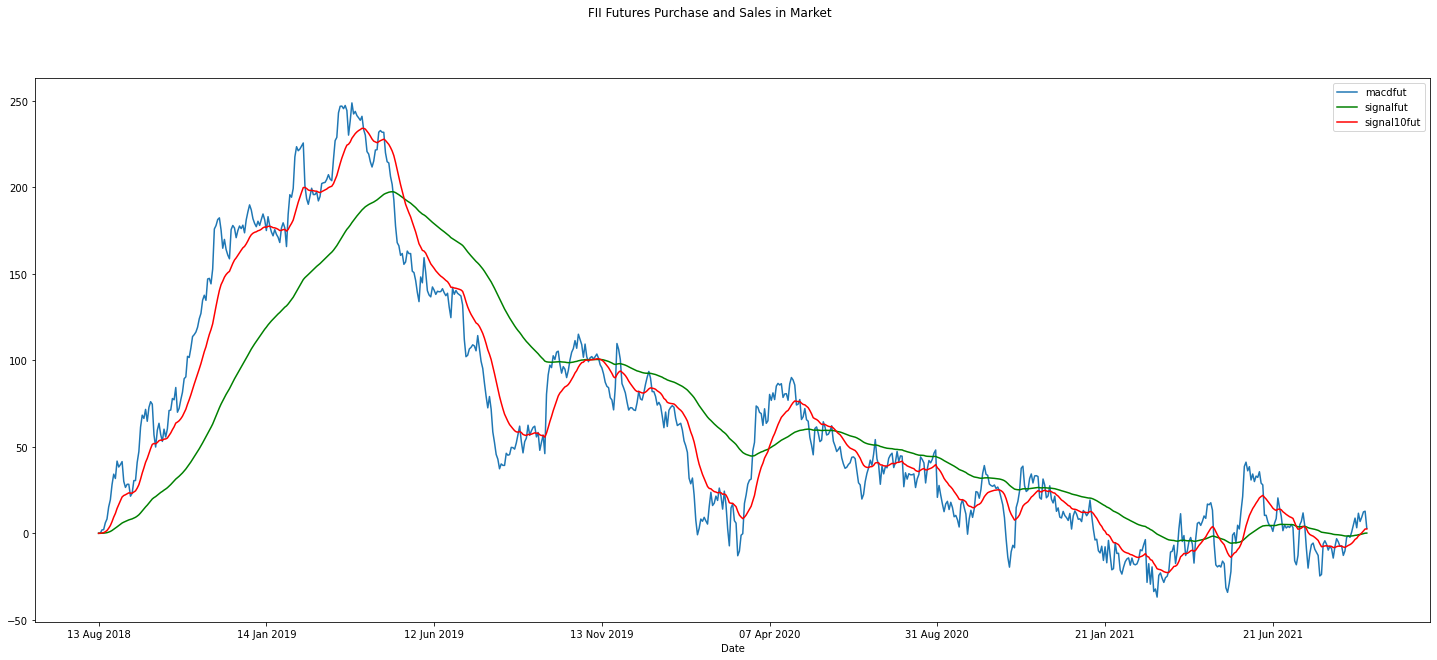

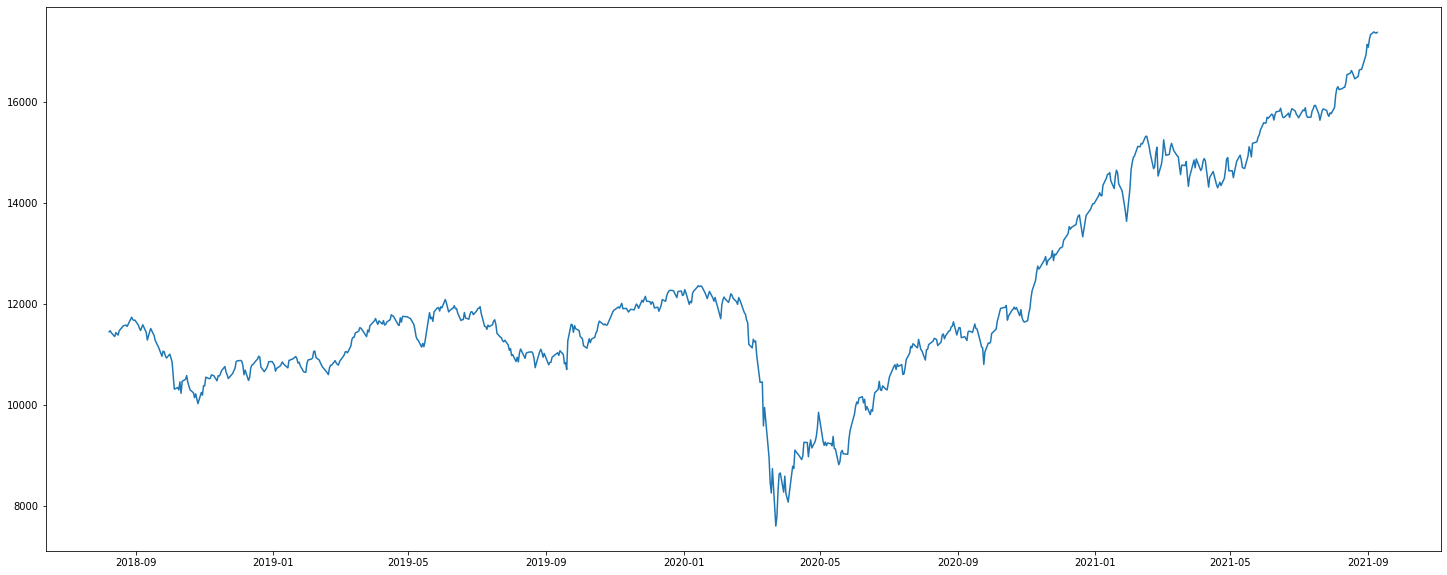

In [23]:
fii_fig['macdfut'].plot(figsize=(25,10))
fii_fig['signalfut'].plot(color='g')
fii_fig['signal10fut'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Futures Purchase and Sales in Market')
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
plt.show()

# Plot FII minus DII

In [24]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=50, adjust=False).mean()-fii_fig['Cash'].ewm(span=100, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=25,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=10,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

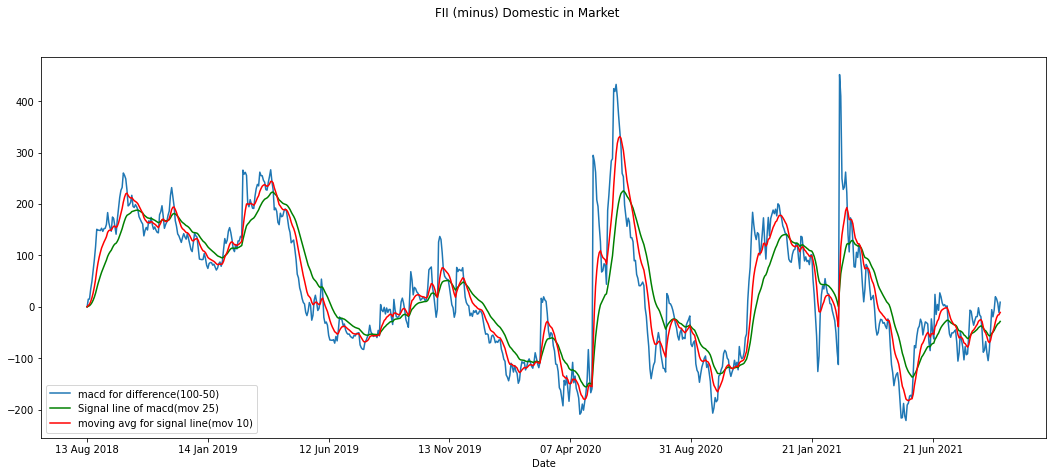

In [25]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(100-50)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 25)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 10)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [26]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=100, adjust=False).mean()-fii_fig['Cash'].ewm(span=250, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=45,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=20,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

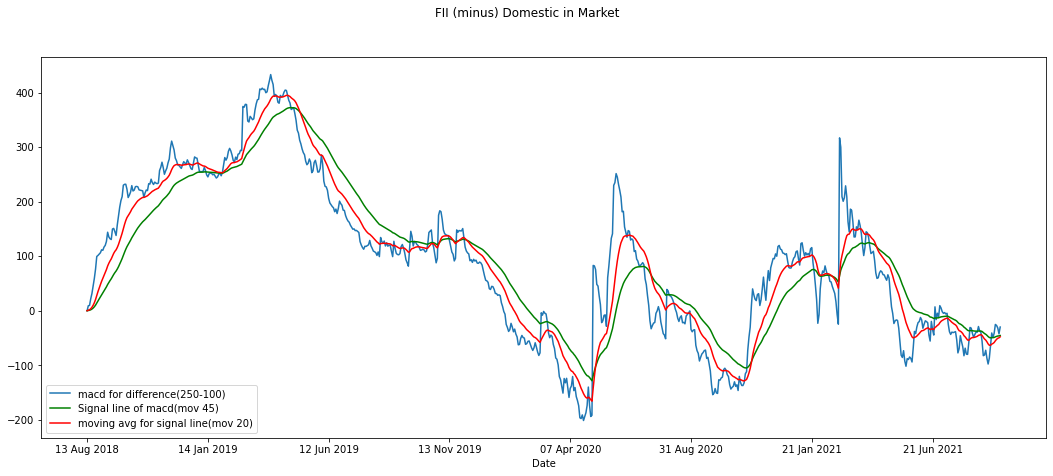

In [27]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(250-100)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 45)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 20)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [28]:
fii_fig['macd']=fii_fig['DIIcash'].ewm(span=50, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal']

In [29]:
fii_fig['macdx']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signalx']=fii_fig['macdx'].ewm(span=35,adjust=False).mean()
fii_fig['signal10x']=fii_fig['macdx'].ewm(span=10,adjust=False).mean()
fii_fig['histx']=fii_fig['macdx']-fii_fig['signalx']

# Plot FII , DII , Difference comparison

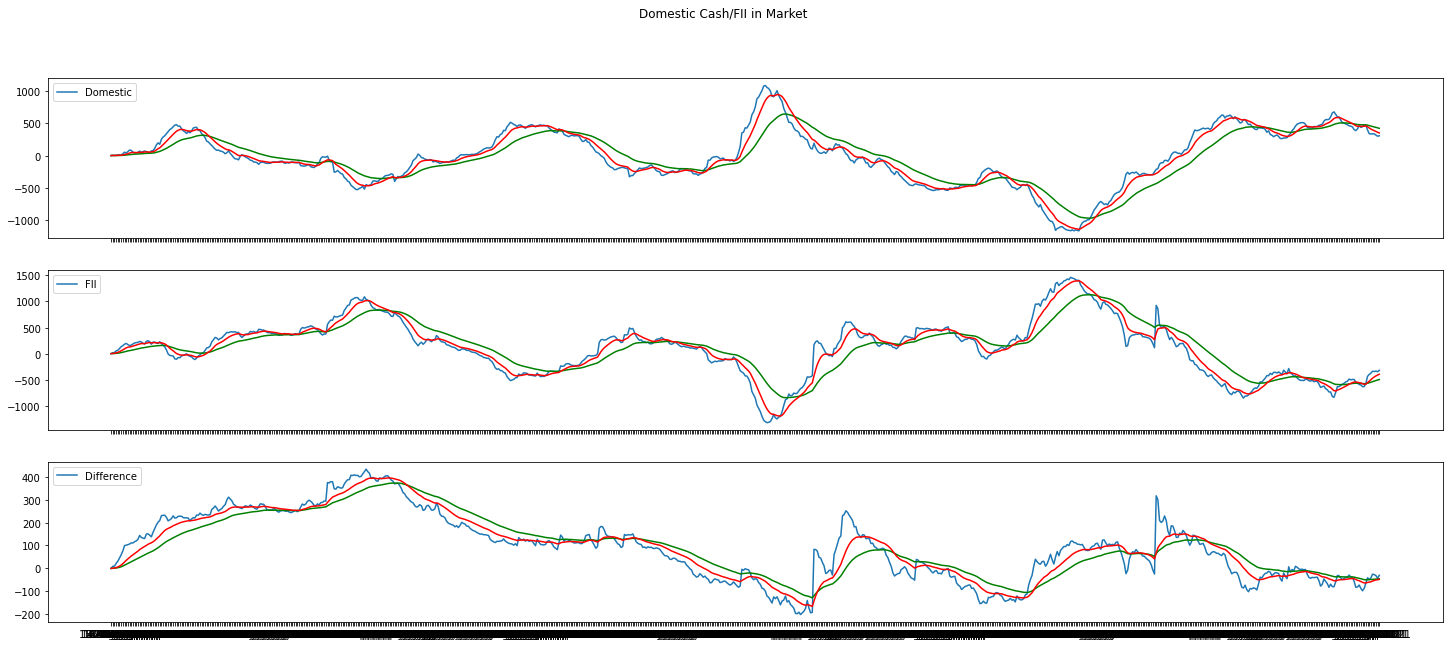

No handles with labels found to put in legend.


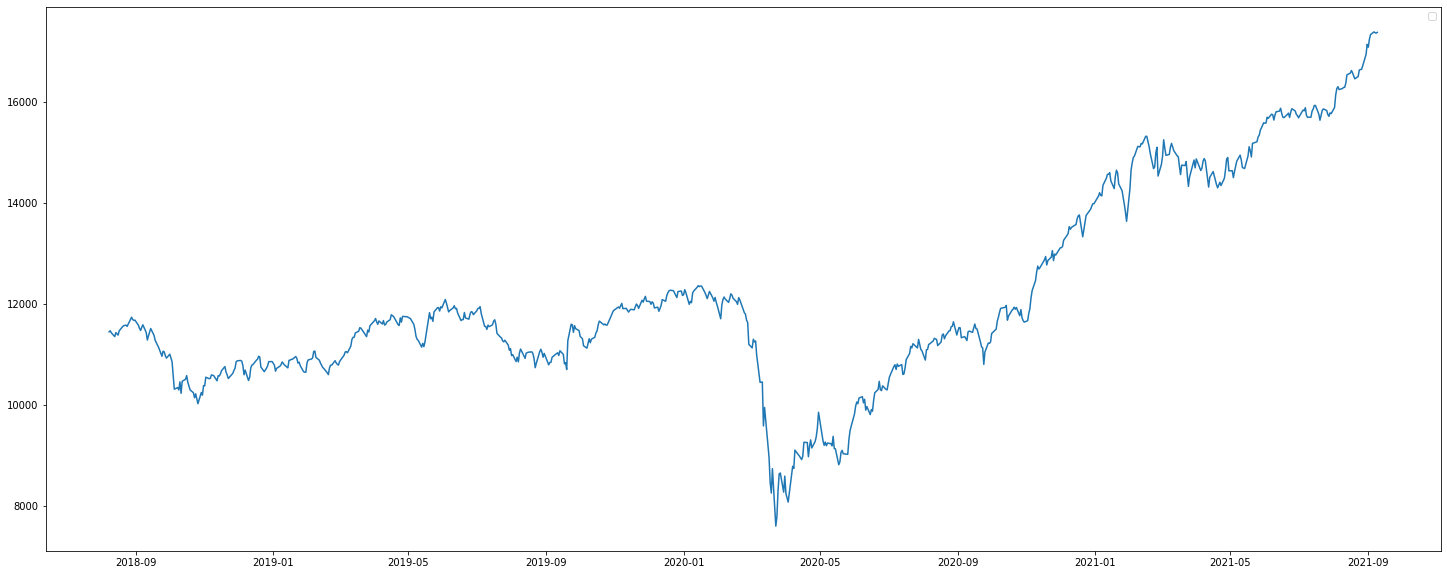

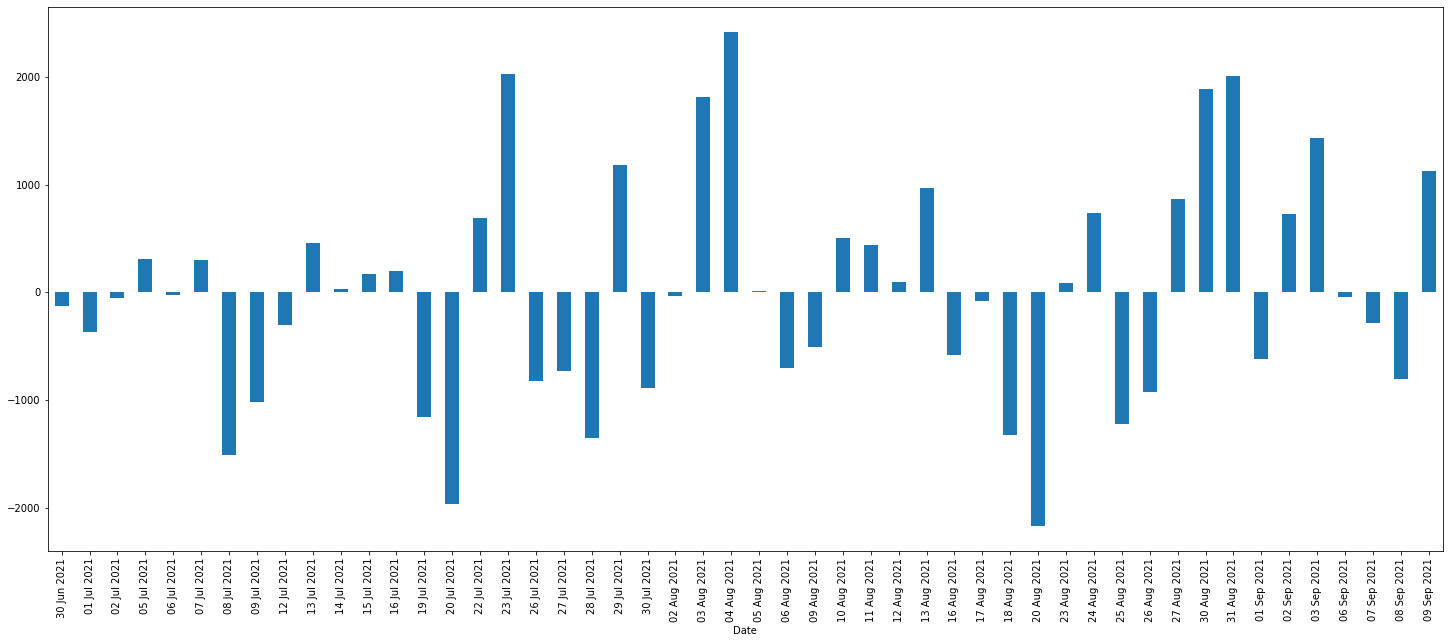

In [30]:
fig,ax=plt.subplots(3,1,figsize=(25,10),sharex=True)
ax[0].plot(fii_fig['macd'], label='Domestic')
ax[0].plot(fii_fig['signal'],color='g')
ax[0].plot(fii_fig['signal10'],color='r')
ax[2].plot(fii_fig['macdy'],label='Difference')
ax[2].plot(fii_fig['signaly'],color='g')
ax[2].plot(fii_fig['signal10y'],color='r')
#plt.plot(fii_fig.loc[:, :].index)
ax[1].plot(fii_fig['macdx'],label='FII')
ax[1].plot(fii_fig['signalx'],color='g')
ax[1].plot(fii_fig['signal10x'],color='r')

#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('Domestic Cash/FII in Market')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
#plt.xaxis.set_major_locator(mloc)
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
fii_fig['Cash'][-50:].plot.bar()
plt.show()

In [31]:
fii_fig.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Cash,macdfut,signalfut,signal10fut,histfut,macdy,signaly,signal10y,histy,macd,signal,signal10,hist,macdx,signalx,signal10x,histx
Date,,,,,,,,,,,,,,,,,,,,,,,
08 Sep 2021,-52.1,-49.8,44,15031,-803,1,-802,12.780035,0.081932,2.489959,12.698103,-42.429540,-46.252547,-49.774221,3.823006,299.891052,428.246725,359.618956,-128.355673,-346.151441,-506.078611,-412.187721,159.92717
09 Sep 2021,48.9,56.9,-1517,14902,423,704,1127,2.867825,0.139971,2.525946,2.727853,-29.986211,-45.545315,-47.889649,15.559104,305.425402,421.423318,349.765582,-115.997916,-320.958914,-495.794184,-395.600665,174.83527


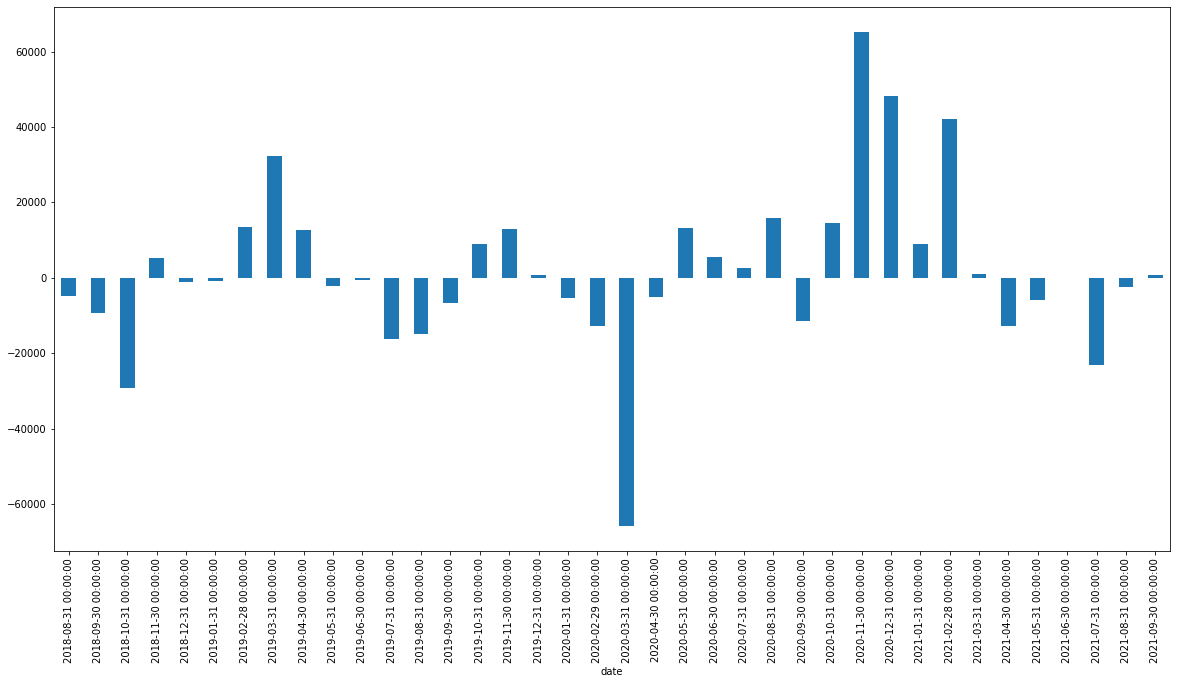

In [32]:
fii_fig=fii_fig.reset_index()
fii_fig['date']=pd.to_datetime(fii_fig['Date'])
fii_fig = fii_fig.set_index('date')
fii_fig.FIICash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

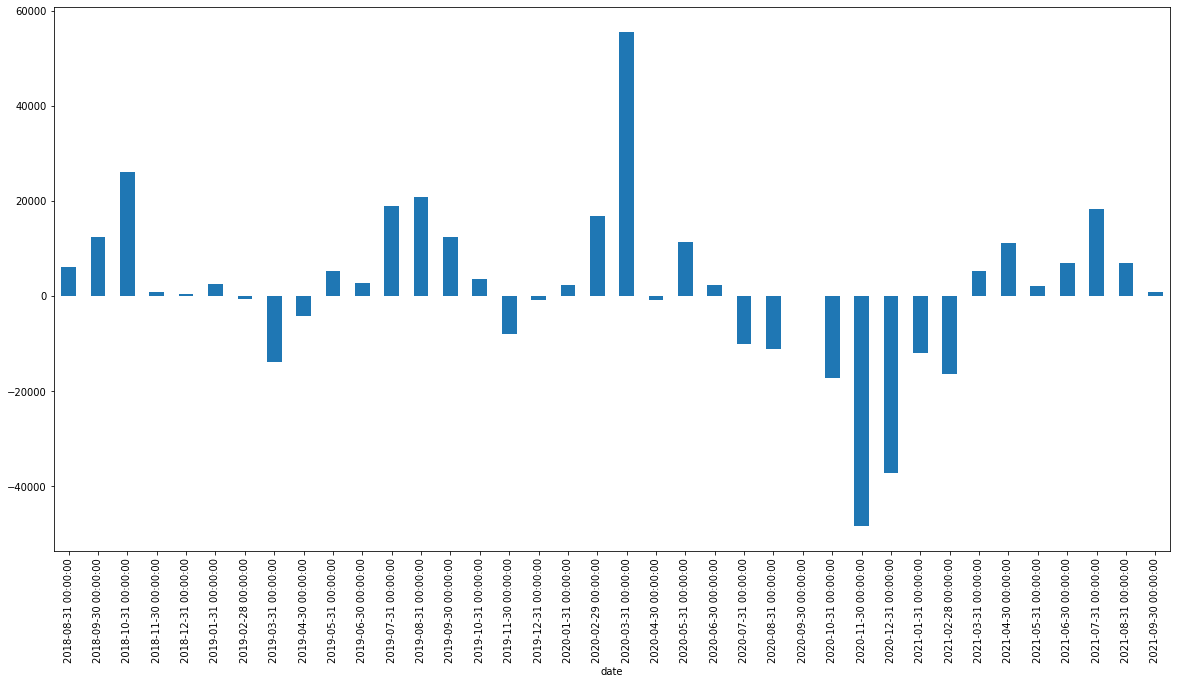

In [33]:
fii_fig.DIIcash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

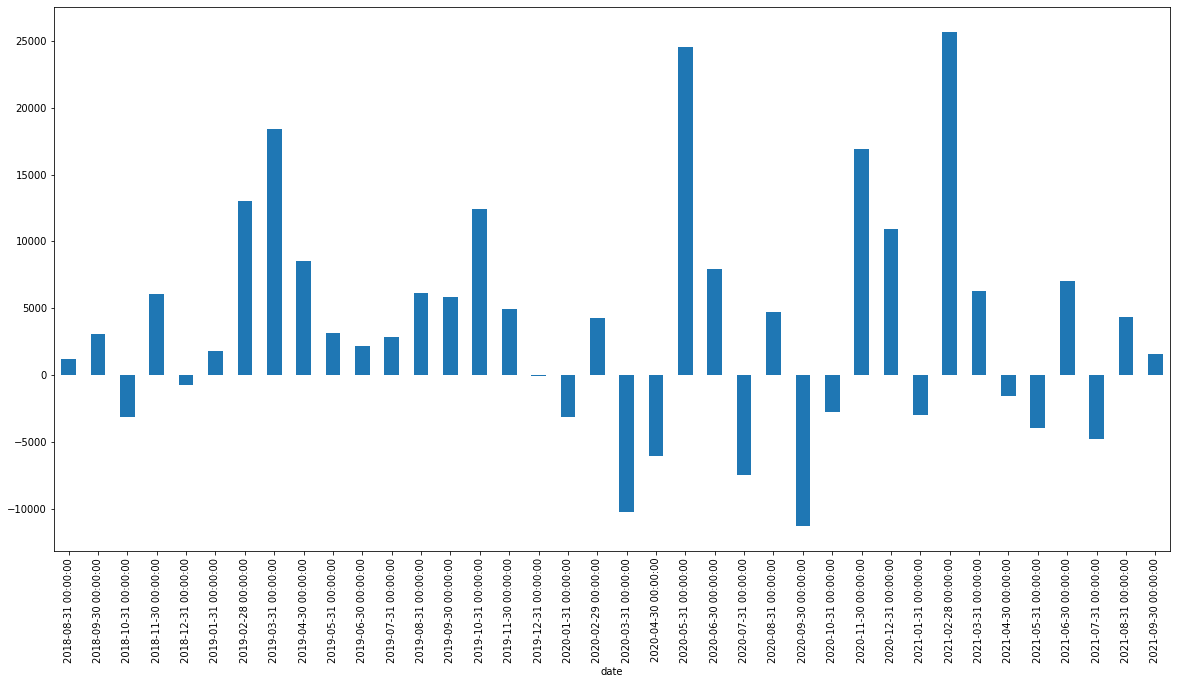

In [34]:
fii_fig.Cash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()


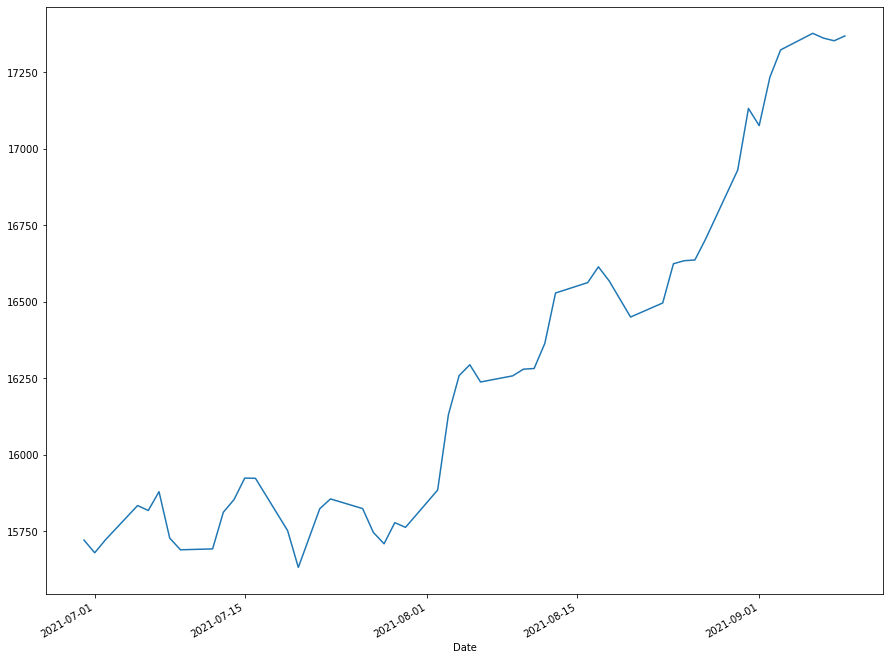

In [35]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [36]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [37]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 


In [38]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=100, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=50,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

In [39]:


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

# Plot Smart Money (FII)

In [40]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['signal10'], mode='lines', name = 'signal10'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(height=500, width=900,
                  title_text="Smart Money And Nifty")

fig.show()

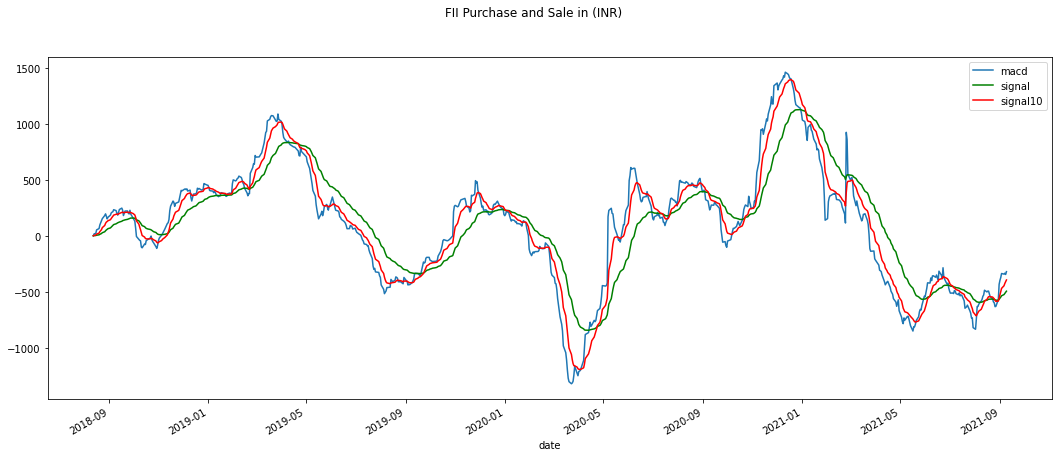

In [41]:
fii_fig['macd'].plot(figsize=(18,7))
fii_fig['signal'].plot(color='g')
fii_fig['signal10'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Purchase and Sale in (INR)')
plt.legend()
plt.show()


In [42]:
fii_fig['fsig']=np.where(fii_fig['macd']>fii_fig['signal10'],1,0)

In [43]:
fii_fig['fsig'].tail(20)

date
2021-08-12    1
2021-08-13    1
2021-08-16    1
2021-08-17    1
2021-08-18    1
2021-08-20    1
2021-08-23    0
2021-08-24    0
2021-08-25    0
2021-08-26    0
2021-08-27    0
2021-08-30    1
2021-08-31    1
2021-09-01    1
2021-09-02    1
2021-09-03    1
2021-09-06    1
2021-09-07    1
2021-09-08    1
2021-09-09    1
Name: fsig, dtype: int64

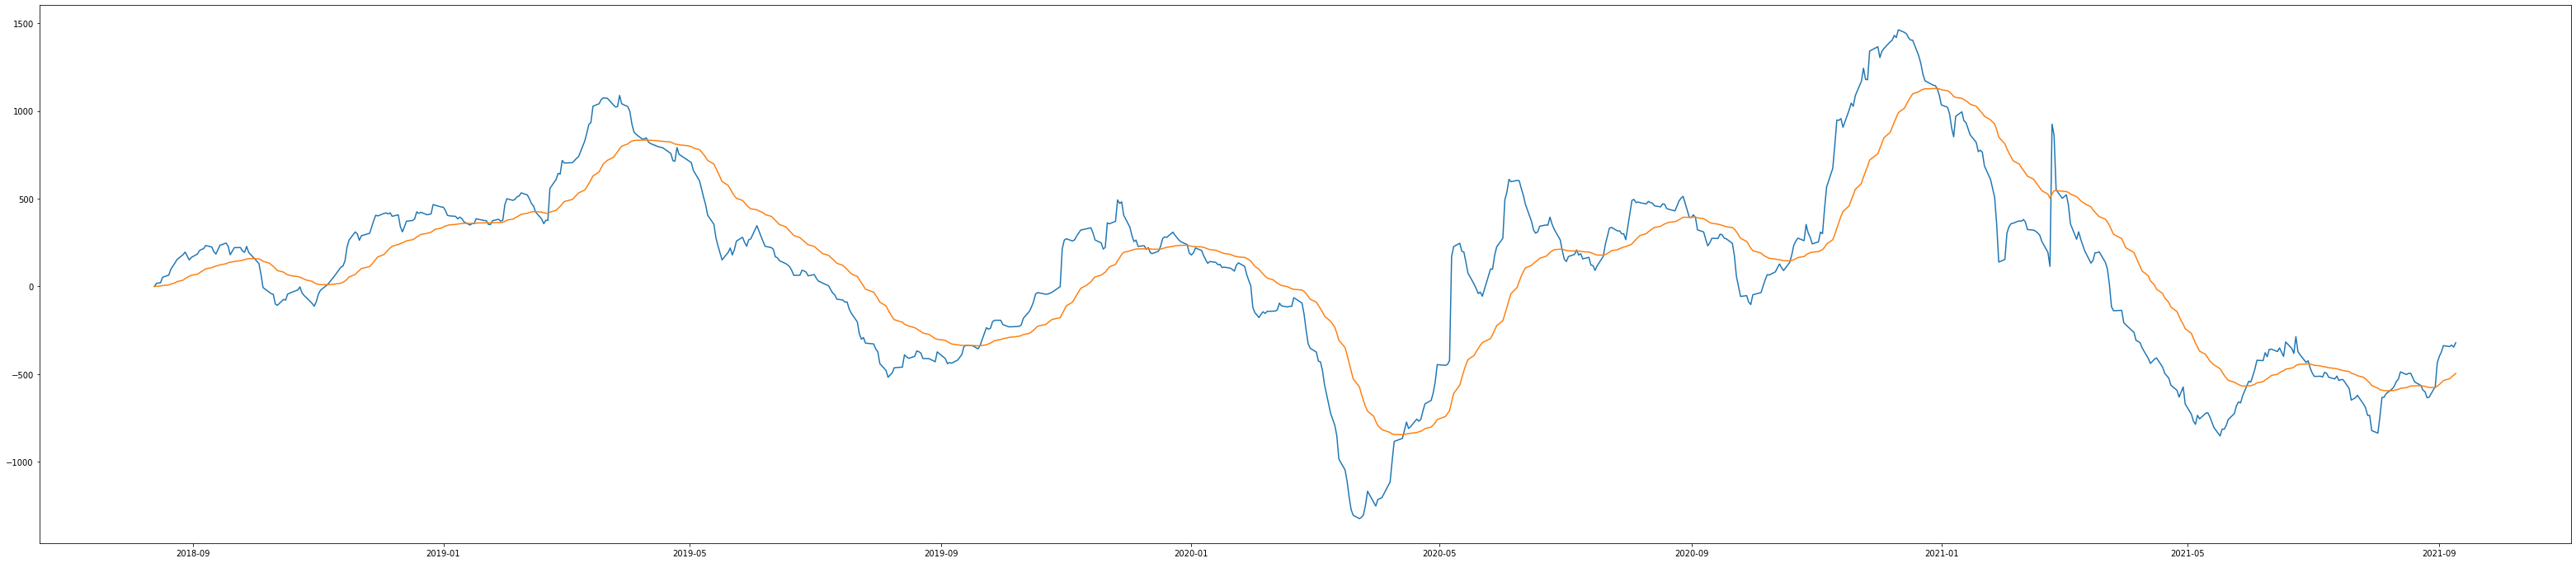

In [44]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()

In [45]:
nifty=nifty.reset_index()

In [46]:
nif.shape,df.macd.shape

((756, 7), (757,))

In [47]:
sample= pd.concat([nif['Close'] ,df['signal']][-len(nif):],axis=1)
sample=sample.replace(0,0.1)

In [48]:
sample['pct_chg']=sample['Close'].pct_change()
sample['macd_chg']=sample['signal'].pct_change()


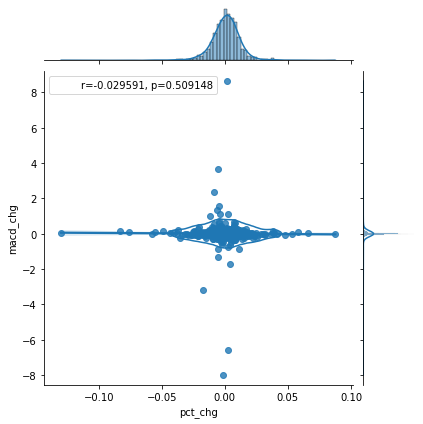

In [49]:
import seaborn as sns
from scipy.stats import pearsonr
g=sns.jointplot(x='pct_chg',y='macd_chg',data=sample,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(sample['pct_chg'][-500:], sample['macd_chg'][-500:])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.show()

# Call n Put Purchase/Sale

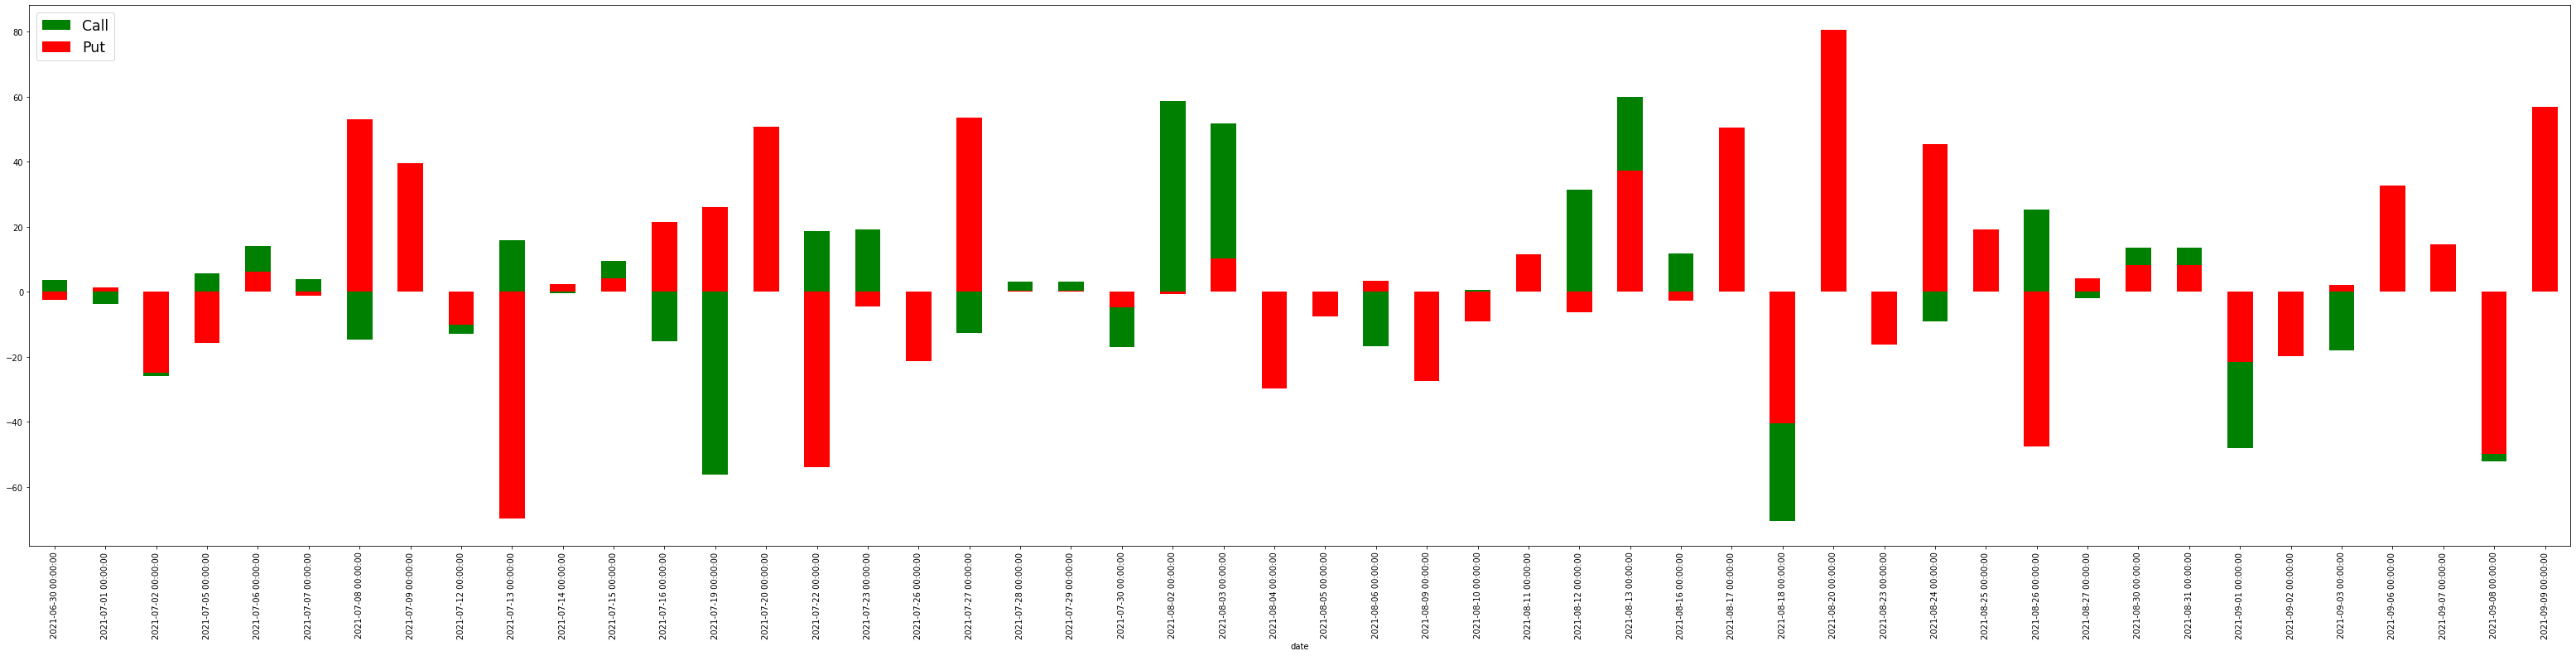

In [50]:
#fii_fig['FIIcall'][-200:].plot(kind='line',figsize=(55,12))
fii_fig['FIIcall'][-50:].plot(color='g',kind='bar',figsize=(55,12),label='Call')

fii_fig['FIIput'][-50:].plot(color='r',kind='bar',figsize=(55,12),label='Put')
plt.legend(loc='upper left',fontsize='xx-large')
plt.show()


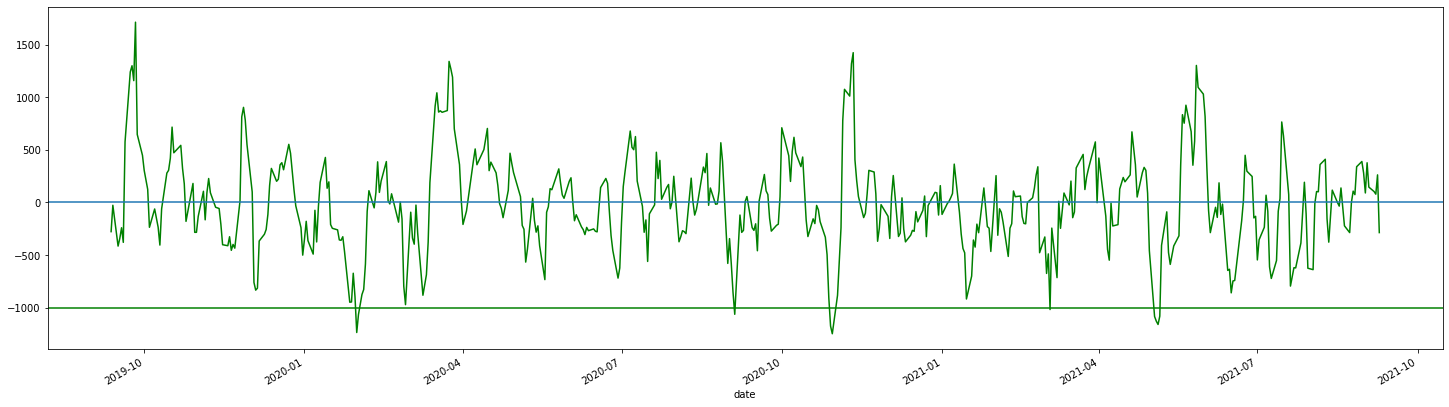

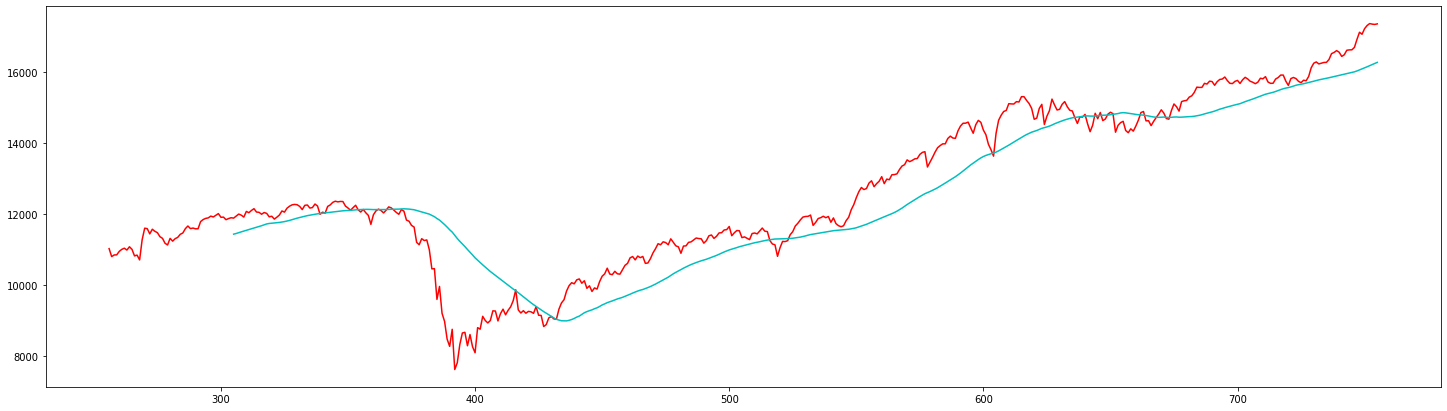

In [51]:
#fii_fig['FIIFuture'][-100:].plot(color='g',kind='line',figsize=(55,12))
fii_fig['FIIFuture'][-500:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(25,7))
plt.axhline(y=0)
plt.axhline(y=-1000, color='g')
plt.show()
nifty['Close'][-500:].plot(color='r',kind='line',figsize=(25,7))
nifty['Close'][-500:].rolling(window=50).mean().plot(color='c',kind='line',figsize=(25,7))
plt.show()

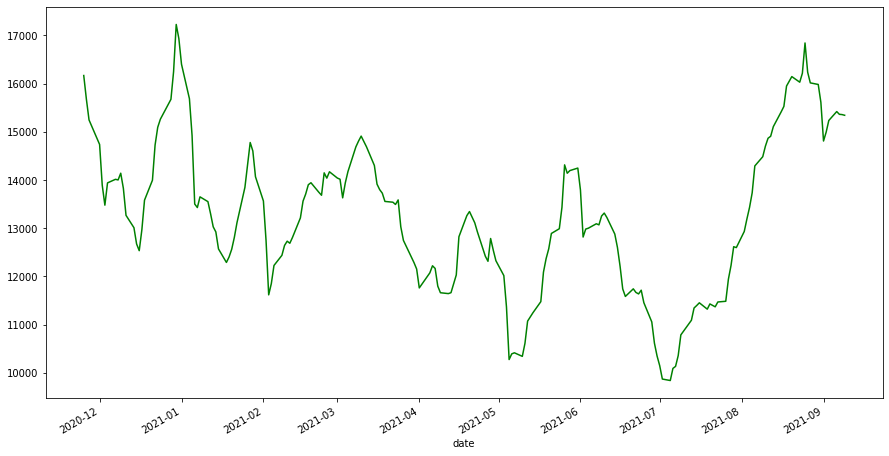

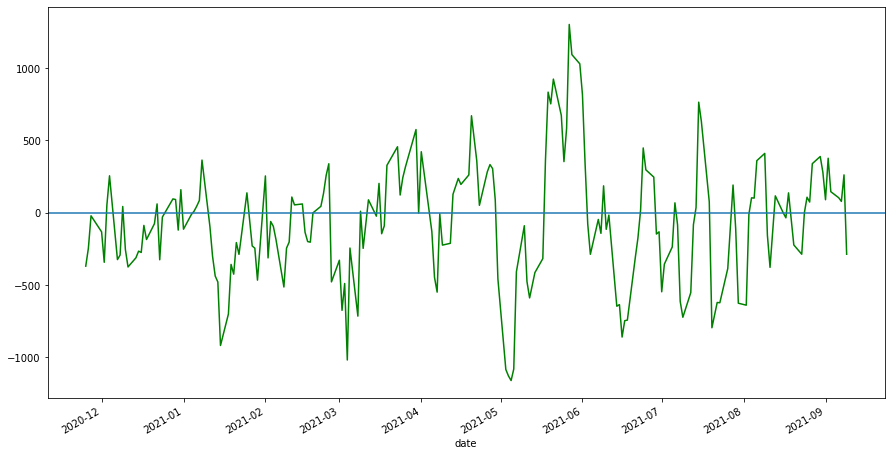

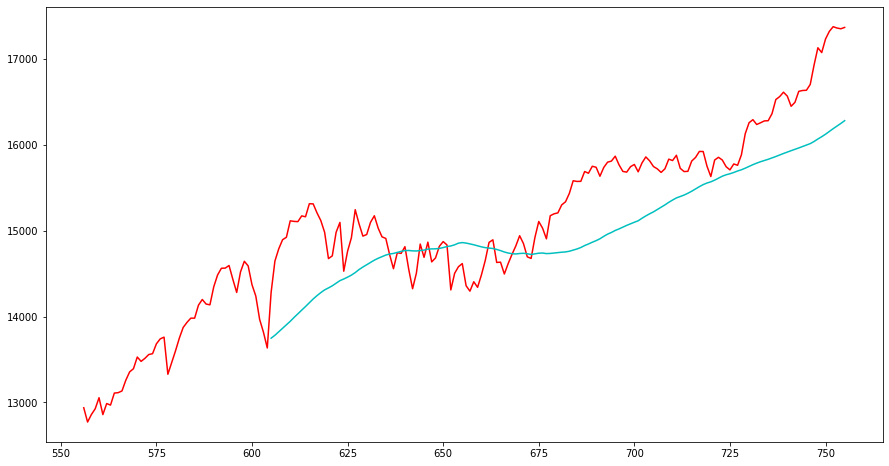

In [52]:
#fii_fig['FIIFuture'][-100:].plot(color='g',kind='line',figsize=(55,12))
fii_fig['FIIFutOI'][-200:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(15,8))
plt.show()
fii_fig['FIIFuture'][-200:].rolling(window=5).mean().plot(color='g',kind='line',figsize=(15,8))
plt.axhline(y=0)
plt.show()
nifty['Close'][-200:].plot(color='r',kind='line',figsize=(15,8))
nifty['Close'][-200:].rolling(window=50).mean().plot(color='c',kind='line',figsize=(15,8))
plt.show()